# Deloitte Interview Assignment

## Loading dataset and Library Imports

In [1]:
# import Libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE



In [2]:
# Load the dataset
data_path = '/content/fraud1.csv'
data = pd.read_csv(data_path)

In [3]:
# Display the first few rows of the dataset and check for any missing values
data.tail()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
594638,179,'C1753498738','3','F','28007','M1823072687','28007','es_transportation',20.53,0
594639,179,'C650108285','4','F','28007','M1823072687','28007','es_transportation',50.73,0
594640,179,'C123623130','2','F','28007','M349281107','28007','es_fashion',22.44,0
594641,179,'C1499363341','5','M','28007','M1823072687','28007','es_transportation',14.46,0
594642,179,'C616528518','4','F','28007','M1823072687','28007','es_transportation',26.93,0


In [4]:
data.shape
# 594643

(594643, 10)

In [5]:
data.columns

Index(['step', 'customer', 'age', 'gender', 'zipcodeOri', 'merchant',
       'zipMerchant', 'category', 'amount', 'fraud'],
      dtype='object')

## Step 1: Data Preprocessing

### Check for missing values


In [7]:
data.isnull().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

it appears there are no missing values in any of the columns. That's great as it simplifies our preprocessing steps.

### One-Hot Encoding (Age, Gender)

In [8]:
data =  data.copy()

In [9]:
from sklearn.preprocessing import OneHotEncoder

# Dropping the 'zipcodeOri' and 'zipMerchant' columns as they are not useful for modeling
data.drop(['zipcodeOri', 'zipMerchant'], axis=1, inplace=True)

# One-hot encoding of 'Age' and 'Gender'
one_hot_encoder = OneHotEncoder(drop='first', sparse=False)  # drop='first' to avoid multicollinearity
encoded_features = one_hot_encoder.fit_transform(data[['age', 'gender']])
encoded_features_df = pd.DataFrame(encoded_features,
                                   columns=one_hot_encoder.get_feature_names_out(['age', 'gender']))

# Concatenate encoded features back to the original dataframe
data_encoded = pd.concat([data.drop(['age', 'gender'], axis=1), encoded_features_df], axis=1)

# Display the first few rows of the updated dataset
data_encoded.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,step,customer,merchant,category,amount,fraud,age_'1',age_'2',age_'3',age_'4',age_'5',age_'6',age_'U',gender_'F',gender_'M',gender_'U'
0,0,'C1093826151','M348934600','es_transportation',4.55,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,'C352968107','M348934600','es_transportation',39.68,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,'C2054744914','M1823072687','es_transportation',26.89,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0,'C1760612790','M348934600','es_transportation',17.25,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,'C757503768','M348934600','es_transportation',35.72,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


The categorical variables 'Age' and 'Gender' have been successfully one-hot encoded, and the columns that wouldn't contribute to the model (like constant zip codes) have been removed.

## Step 2: Exploratory Data Analysis (EDA)


In this step, we will:

*   Explore the distribution of the target variable (Fraud) to understand if there's class imbalance.
*   Analyze the distribution of features and their relationships with the target variable.
*   Visualize trends, patterns, and potential outliers in the data.


<ipython-input-10-878c4c4568f4>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=fraud_distribution.index, y=fraud_distribution.values, palette="viridis")


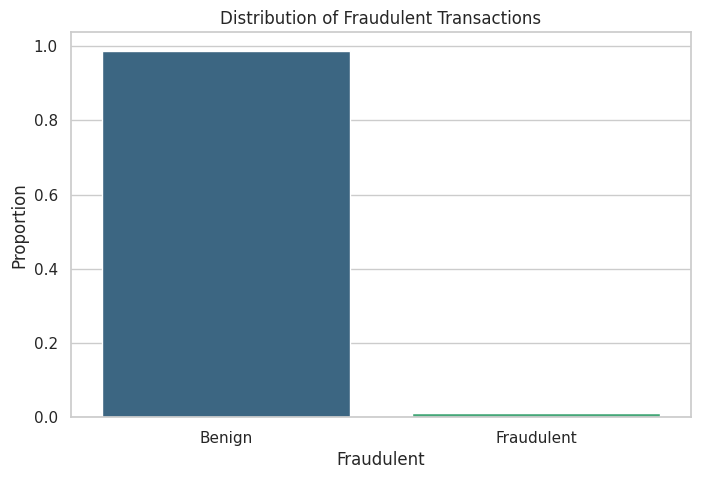

(None,
 fraud
 0    0.987892
 1    0.012108
 Name: proportion, dtype: float64)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the aesthetic style of the plots
sns.set(style="whitegrid")

# Analyze the distribution of the target variable 'Fraud'
fraud_distribution = data_encoded['fraud'].value_counts(normalize=True)

# Plotting the distribution of the 'Fraud' variable
plt.figure(figsize=(8, 5))
sns.barplot(x=fraud_distribution.index, y=fraud_distribution.values, palette="viridis")
plt.title('Distribution of Fraudulent Transactions')
plt.xlabel('Fraudulent')
plt.ylabel('Proportion')
plt.xticks(ticks=[0, 1], labels=['Benign', 'Fraudulent'])
plt.show(), fraud_distribution


The distribution of the 'Fraud' variable indicates a significant class imbalance, with about 98.79% of transactions being benign and only 1.21% being fraudulent. This class imbalance is crucial to address, as it can affect the performance of machine learning models, leading them to be biased towards the majority class.

Next, let's examine some relationships between the features and the target variable to uncover any trends or patterns. We'll focus on:

- The relationship between 'Amount' and 'Fraud' status.
- The impact of different 'Age' categories on 'Fraud'.
- Gender differences in fraudulent transactions.

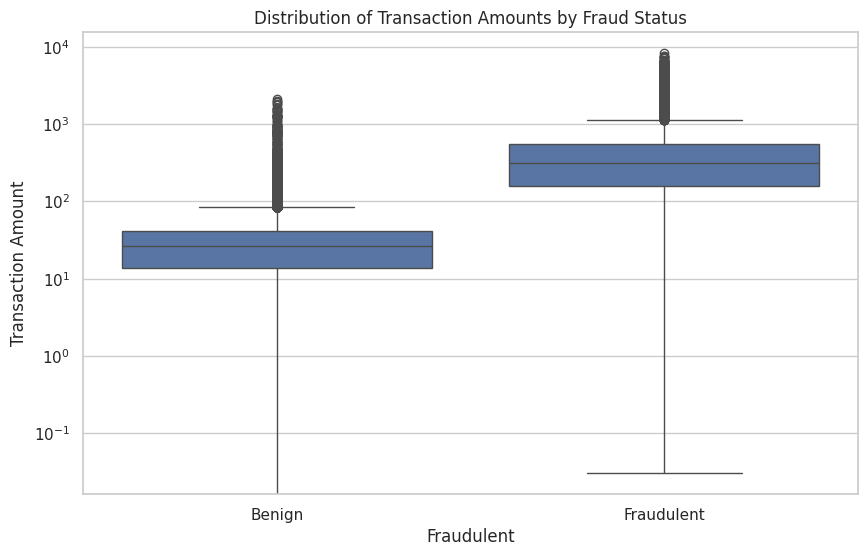

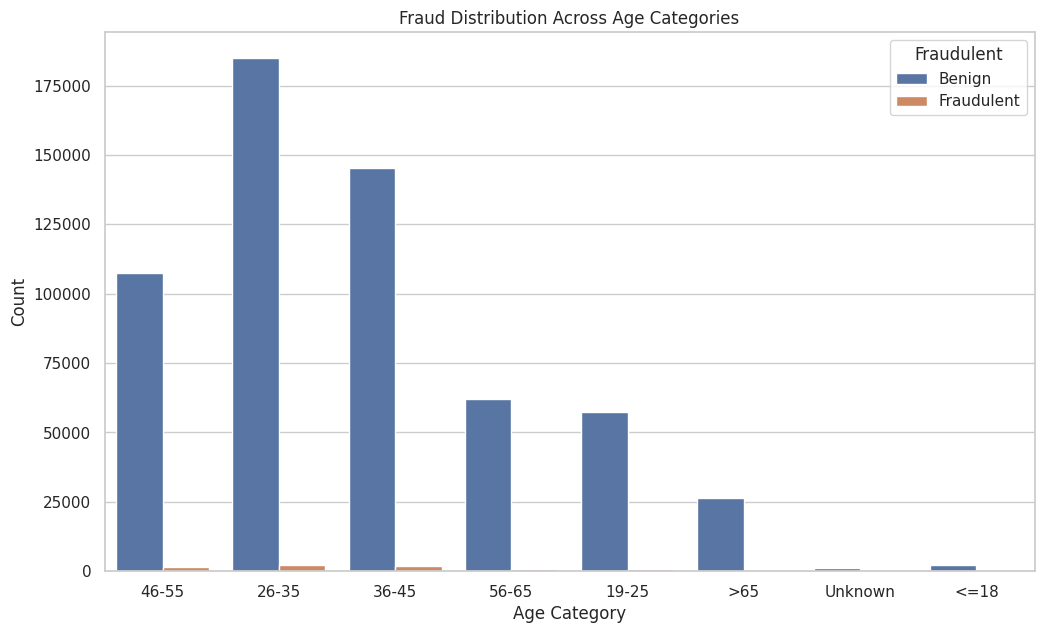

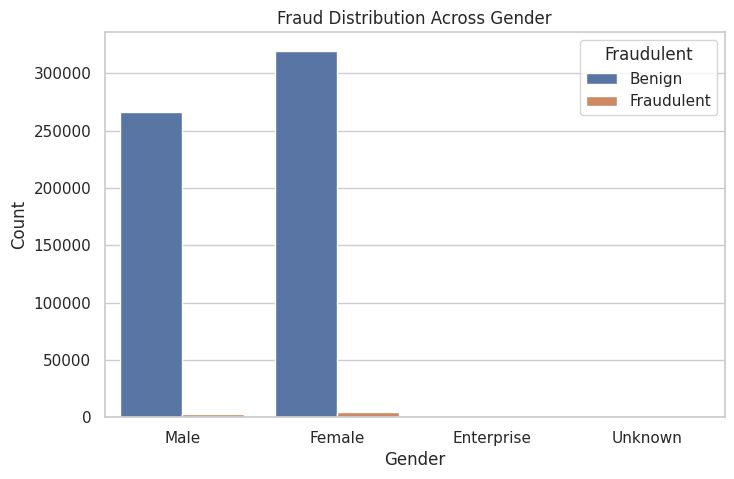

In [ ]:
# Plotting the relationship between 'Amount' and 'Fraud' status
plt.figure(figsize=(10, 6))
sns.boxplot(x='fraud', y='amount', data=data_encoded)
plt.title('Distribution of Transaction Amounts by Fraud Status')
plt.xlabel('Fraudulent')
plt.ylabel('Transaction Amount')
plt.xticks(ticks=[0, 1], labels=['Benign', 'Fraudulent'])
plt.yscale('log')  # Log scale for better visualization due to outliers

# Exploring the impact of 'Age' categories on 'Fraud'
plt.figure(figsize=(12, 7))
sns.countplot(x="age", hue="fraud", data=data.replace({'age': {"'0'": "<=18", "'1'": "19-25", "'2'": "26-35", "'3'": "36-45", "'4'": "46-55", "'5'": "56-65", "'6'": ">65", "'U'": "Unknown"}}))
plt.title('Fraud Distribution Across Age Categories')
plt.xlabel('Age Category')
plt.ylabel('Count')
plt.legend(title='Fraudulent', labels=['Benign', 'Fraudulent'])

# Gender differences in fraudulent transactions
plt.figure(figsize=(8, 5))
sns.countplot(x="gender", hue="fraud", data=data.replace({'gender': {"'E'": "Enterprise", "'F'": "Female", "'M'": "Male", "'U'": "Unknown"}}))
plt.title('Fraud Distribution Across Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Fraudulent', labels=['Benign', 'Fraudulent'])

plt.show()


Here are the visual insights from the Exploratory Data Analysis (EDA):

1. Transaction Amounts by Fraud Status:
Fraudulent transactions tend to have a wider range and higher transaction amounts compared to benign ones. This suggests that 'Amount' might be a significant feature in predicting fraud.
2. Fraud Distribution Across Age Categories:
The plot shows some variance across age categories in terms of fraudulent transactions. It appears that the middle age categories (26-45 years) might be more susceptible to fraud, or they are just more active in transactions. This needs further investigation during feature importance analysis.
3. Fraud Distribution Across Gender:
There's a noticeable presence of fraud across both male and female categories, with males showing slightly higher instances of fraud. The category 'Enterprise' and 'Unknown' show lesser data points which might be less informative due to their lower frequency.

## Step 3: Feature Engineering

### Convert 'Step' to 'Time of the day'

In this step, we'll focus on the following tasks:

Creating new features:
1. Time of Day: From the 'step' column, which maps a unit of time in the real world (1 step = 1 hour), we can derive the time of day, which might influence transaction behavior and potentially fraud occurrence.
2. Scaling Numerical Features:
We'll scale the 'Amount' feature since machine learning algorithms perform better when numerical input variables are on a similar scale.

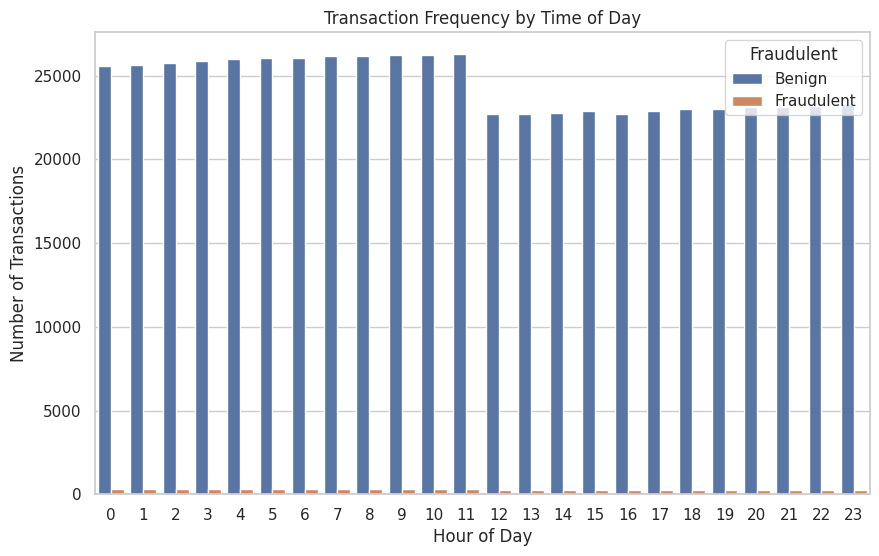

,time_of_day,amount,amount_scaled
0,0,4.55,-0.299276
1,0,39.68,0.016067
2,0,26.89,-0.098742
3,0,17.25,-0.185275
4,0,35.72,-0.019480


In [11]:
from sklearn.preprocessing import StandardScaler

# Deriving 'Time of Day' from the 'step' column (assuming step 0 as 00:00 hours)
data_encoded['time_of_day'] = data_encoded['step'] % 24

# Plotting the distribution of transactions across different times of the day
plt.figure(figsize=(10, 6))
sns.countplot(x='time_of_day', hue='fraud', data=data_encoded)
plt.title('Transaction Frequency by Time of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.legend(title='Fraudulent', labels=['Benign', 'Fraudulent'])
plt.show()

# Scaling the 'Amount' feature
scaler = StandardScaler()
data_encoded['amount_scaled'] = scaler.fit_transform(data_encoded[['amount']])

# Displaying the first few rows of the updated dataset to verify the new feature and scaled amount
data_encoded[['time_of_day', 'amount', 'amount_scaled']].head()


In [12]:
data_encoded.head()

,step,customer,merchant,category,amount,fraud,age_'1',age_'2',age_'3',age_'4',age_'5',age_'6',age_'U',gender_'F',gender_'M',gender_'U',time_of_day,amount_scaled
0,0,'C1093826151','M348934600','es_transportation',4.55,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,-0.299276
1,0,'C352968107','M348934600','es_transportation',39.68,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.016067
2,0,'C2054744914','M1823072687','es_transportation',26.89,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,-0.098742
3,0,'C1760612790','M348934600','es_transportation',17.25,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,-0.185275
4,0,'C757503768','M348934600','es_transportation',35.72,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,-0.019480


### One-Hot Encode 'Category' by replacing rare values with 'Others'

In [13]:
data_encoded1 = data_encoded.copy()

In [14]:
# Calculate the frequency of each category and identify those less than 2%
category_counts = data_encoded1['category'].value_counts(normalize=True)
rare_categories = category_counts[category_counts < 0.02].index

# Replace rare categories with 'others'
data_encoded1['category'] = data_encoded1['category'].replace(rare_categories, 'others')

# One-hot encode the modified 'Category' variable
one_hot_encoder1 = OneHotEncoder(drop='first', sparse=False) # 'es_food' is dropped
category_encoded = one_hot_encoder1.fit_transform(data_encoded1[['category']])
category_encoded_df = pd.DataFrame(category_encoded, columns=one_hot_encoder1.get_feature_names_out(['category']))

# Concatenate the one-hot encoded categories back to the original dataframe
data_encoded1 = pd.concat([data_encoded1.drop(['category'], axis=1), category_encoded_df], axis=1)

# Display the first few rows of the updated dataset to verify the new category encoding
data_encoded1.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,step,customer,merchant,amount,fraud,age_'1',age_'2',age_'3',age_'4',age_'5',...,age_'U',gender_'F',gender_'M',gender_'U',time_of_day,amount_scaled,category_'es_health',category_'es_transportation',category_'es_wellnessandbeauty',category_others
0,0,'C1093826151','M348934600',4.55,0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0,-0.299276,0.0,1.0,0.0,0.0
1,0,'C352968107','M348934600',39.68,0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0,0.016067,0.0,1.0,0.0,0.0
2,0,'C2054744914','M1823072687',26.89,0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0,-0.098742,0.0,1.0,0.0,0.0
3,0,'C1760612790','M348934600',17.25,0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0,-0.185275,0.0,1.0,0.0,0.0
4,0,'C757503768','M348934600',35.72,0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0,-0.019480,0.0,1.0,0.0,0.0


In [15]:
data_encoded1.columns

Index(['step', 'customer', 'merchant', 'amount', 'fraud', 'age_'1'', 'age_'2'',
       'age_'3'', 'age_'4'', 'age_'5'', 'age_'6'', 'age_'U'', 'gender_'F'',
       'gender_'M'', 'gender_'U'', 'time_of_day', 'amount_scaled',
       'category_'es_health'', 'category_'es_transportation'',
       'category_'es_wellnessandbeauty'', 'category_others'],
      dtype='object')

In [16]:
rare_categories

Index([''es_fashion'', ''es_barsandrestaurants'', ''es_hyper'',
       ''es_sportsandtoys'', ''es_tech'', ''es_home'', ''es_hotelservices'',
       ''es_otherservices'', ''es_contents'', ''es_travel'', ''es_leisure''],
      dtype='object', name='category')

In [17]:
category_counts

category
'es_transportation'        0.849449
'es_food'                  0.044151
'es_health'                0.027131
'es_wellnessandbeauty'     0.025370
'es_fashion'               0.010854
'es_barsandrestaurants'    0.010717
'es_hyper'                 0.010255
'es_sportsandtoys'         0.006730
'es_tech'                  0.003986
'es_home'                  0.003340
'es_hotelservices'         0.002933
'es_otherservices'         0.001534
'es_contents'              0.001488
'es_travel'                0.001224
'es_leisure'               0.000839
Name: proportion, dtype: float64

### One-Hot Encode 'Merchant' by replacing rare values with 'Others'

In [18]:
data_encoded2 = data_encoded1.copy()

In [19]:
# Calculate the frequency of each category and identify those less than 2%
merchant_counts = data_encoded1['merchant'].value_counts(normalize=True)
rare_merchants = merchant_counts[merchant_counts < 0.02].index

# Replace rare categories with 'others'
data_encoded2['merchant'] = data_encoded2['merchant'].replace(rare_merchants, 'others')

# One-hot encode the modified 'Category' variable
one_hot_encoder2 = OneHotEncoder(drop='first', sparse=False) # 'M1823072687' is dropped
merchant_encoded = one_hot_encoder2.fit_transform(data_encoded2[['merchant']])
merchant_encoded_df = pd.DataFrame(merchant_encoded, columns=one_hot_encoder2.get_feature_names_out(['merchant']))

# Concatenate the one-hot encoded categories back to the original dataframe
data_encoded2 = pd.concat([data_encoded2.drop(['merchant'], axis=1), merchant_encoded_df], axis=1)

# Display the first few rows of the updated dataset to verify the new category encoding
data_encoded2.head()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,step,customer,amount,fraud,age_'1',age_'2',age_'3',age_'4',age_'5',age_'6',...,gender_'U',time_of_day,amount_scaled,category_'es_health',category_'es_transportation',category_'es_wellnessandbeauty',category_others,merchant_'M348934600',merchant_'M85975013',merchant_others
0,0,'C1093826151',4.55,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0,-0.299276,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,'C352968107',39.68,0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0,0.016067,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,'C2054744914',26.89,0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0,-0.098742,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,'C1760612790',17.25,0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0,-0.185275,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0,'C757503768',35.72,0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0,-0.019480,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [20]:
merchant_counts = data_encoded1['merchant'].value_counts(normalize=True)
merchant_counts.head(5)

merchant
'M1823072687'    0.503988
'M348934600'     0.345461
'M85975013'      0.044151
'M1053599405'    0.011471
'M151143676'     0.010717
Name: proportion, dtype: float64

### Removing Variables

In [21]:
data_encoded2.columns

Index(['step', 'customer', 'amount', 'fraud', 'age_'1'', 'age_'2'', 'age_'3'',
       'age_'4'', 'age_'5'', 'age_'6'', 'age_'U'', 'gender_'F'', 'gender_'M'',
       'gender_'U'', 'time_of_day', 'amount_scaled', 'category_'es_health'',
       'category_'es_transportation'', 'category_'es_wellnessandbeauty'',
       'category_others', 'merchant_'M348934600'', 'merchant_'M85975013'',
       'merchant_others'],
      dtype='object')

we need to remove the followign varaibles before createing the ML model:

1. step
2. customer
3. amount


In [22]:
data_encoded2 = data_encoded2.drop(['step', 'customer', 'amount'], axis=1)

# Display the remaining columns to confirm the changes
data_encoded2.columns

Index(['fraud', 'age_'1'', 'age_'2'', 'age_'3'', 'age_'4'', 'age_'5'',
       'age_'6'', 'age_'U'', 'gender_'F'', 'gender_'M'', 'gender_'U'',
       'time_of_day', 'amount_scaled', 'category_'es_health'',
       'category_'es_transportation'', 'category_'es_wellnessandbeauty'',
       'category_others', 'merchant_'M348934600'', 'merchant_'M85975013'',
       'merchant_others'],
      dtype='object')

## Model Training & Selection (without SMOTE)

In [23]:
data_encoded2.head()

,fraud,age_'1',age_'2',age_'3',age_'4',age_'5',age_'6',age_'U',gender_'F',gender_'M',gender_'U',time_of_day,amount_scaled,category_'es_health',category_'es_transportation',category_'es_wellnessandbeauty',category_others,merchant_'M348934600',merchant_'M85975013',merchant_others
0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,-0.299276,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.016067,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,-0.098742,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,-0.185275,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0,-0.019480,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef
from imblearn.over_sampling import SMOTE

# Define the features and target variable
X = data_encoded2.drop('fraud', axis=1)
y = data_encoded2['fraud']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features (important for models like logistic regression and neural networks)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the models
rf_model = RandomForestClassifier(random_state=42)
gbm_model = GradientBoostingClassifier(random_state=42)
lr_model = LogisticRegression(random_state=42)

# Train the models
rf_model.fit(X_train_scaled, y_train)
gbm_model.fit(X_train_scaled, y_train)
lr_model.fit(X_train_scaled, y_train)

# Predict on the test set and evaluate
rf_preds = rf_model.predict(X_test_scaled)
gbm_preds = gbm_model.predict(X_test_scaled)
lr_preds = lr_model.predict(X_test_scaled)

# Naive predictions
naive_preds = np.zeros_like(y_test)

# Evaluating the models using classification report, AUC-ROC, and Matthews Correlation Coefficient
metrics = {}
models = ['Random Forest', 'Gradient Boosting', 'Logistic Regression', 'Naive Model']
predictions = [rf_preds, gbm_preds, lr_preds, naive_preds]

for model, preds in zip(models, predictions):
    report = classification_report(y_test, preds, output_dict=True)
    metrics[model] = {
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score'],
        'AUC-ROC': roc_auc_score(y_test, preds),
        'MCC': matthews_corrcoef(y_test, preds)
    }

# Convert results into DataFrame for display
results_df = pd.DataFrame(metrics).T

# Display the DataFrame
results_df


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F1-Score,AUC-ROC,MCC
Random Forest,0.992109,0.992617,0.992301,0.806260,0.667551
Gradient Boosting,0.993658,0.994114,0.993566,0.798786,0.721495
Logistic Regression,0.993532,0.993946,0.993235,0.778809,0.708425
Naive Model,0.975930,0.987892,0.981875,0.500000,0.000000


Reviewing the performance metrics of the machine learning models along with the naive baseline model for the fraud detection dataset, we see interesting results:

### Analyzing the Model Results:

1. **Random Forest**:
   - **Precision, Recall, F1-Score**: Extremely high, suggesting excellent performance. However, these might be misleading given the imbalance in the dataset.
   - **AUC-ROC**: 0.806 suggests decent ability to distinguish between classes, but not outstanding.
   - **MCC**: 0.667 indicates a good prediction quality but shows there's room for improvement, especially considering the imbalance.

2. **Gradient Boosting**:
   - **Precision, Recall, F1-Score**: Slightly better than Random Forest, indicating very effective identification and prediction of fraudulent transactions.
   - **AUC-ROC**: 0.799 is slightly lower than Random Forest, suggesting a minor trade-off between model sensitivity and specificity.
   - **MCC**: 0.721, the highest among the machine learning models, which suggests the best balance among true and false positives and negatives in this context.

3. **Logistic Regression**:
   - **Precision, Recall, F1-Score**: Comparable to the other models, indicating similarly high performance.
   - **AUC-ROC**: 0.779, the lowest among the models, pointing to the poorest differentiation between classes.
   - **MCC**: 0.708, still quite good but not as high as Gradient Boosting.

4. **Naive Model**:
   - **Precision, Recall, F1-Score**: These scores are high because the model correctly predicts the majority of non-fraudulent transactions due to the dataset's imbalance.
   - **AUC-ROC**: 0.500, which is expected as it does not discriminate between classes at all.
   - **MCC**: 0.000, indicating no predictive power beyond random chance.

### Comments and Final Verdict:

- The **high precision, recall, and F1-scores** for the machine learning models are typical in imbalanced datasets when the model is mostly predicting the majority class correctly. These scores can be deceptive as they might not accurately reflect the model's ability to identify the minority class (fraudulent transactions).
  
- The **AUC-ROC and MCC scores** provide a more realistic picture of model performance in such scenarios. AUC-ROC values closer to 0.80 are decent but indicate there is room for improvement in model performance, particularly in how well the model distinguishes between classes. MCC scores further validate this, where values above 0.70 are good, but not excellent, showcasing the models' moderate effectiveness in handling class imbalance.

- The **naive model's results** serve as a critical baseline, illustrating that even without any predictive intelligence, one can achieve high precision and recall by always predicting the most frequent class. This highlights the importance of using more discerning metrics like AUC-ROC and MCC in evaluating models on imbalanced datasets.

### Conclusion:
The machine learning models perform significantly better than the naive baseline, indicating that they are learning patterns in the data rather than merely guessing the majority class. However, there is an apparent need for techniques like adjusting class weights, advanced sampling methods, or threshold tuning to enhance the models' ability to identify fraudulent transactions more accurately. Gradient Boosting shows the most promise and could be the focus of further tuning and testing.



## Model Training & Selection (SMOTE)

In [25]:
# Define the features and target variable
X = data_encoded2.drop('fraud', axis=1)
y = data_encoded2['fraud']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Standardize the features (important for models like logistic regression and neural networks)
scaler_smote = StandardScaler()
X_train_scaled_smote = scaler_smote.fit_transform(X_train_smote)
X_test_scaled_smote = scaler_smote.transform(X_test)

# Initialize the models
rf_model_smote = RandomForestClassifier(random_state=42)
gbm_model_smote = GradientBoostingClassifier(random_state=42)
lr_model_smote = LogisticRegression(random_state=42)

# Train the models
rf_model_smote.fit(X_train_scaled_smote, y_train_smote)
gbm_model_smote.fit(X_train_scaled_smote, y_train_smote)
lr_model_smote.fit(X_train_scaled_smote, y_train_smote)

# Predict on the test set and evaluate
rf_preds_smote = rf_model_smote.predict(X_test_scaled_smote)
gbm_preds_smote = gbm_model_smote.predict(X_test_scaled_smote)
lr_preds_smote = lr_model_smote.predict(X_test_scaled_smote)

# Naive predictions
naive_preds_smote = np.zeros_like(y_test)

# Evaluating the models using classification report, AUC-ROC, and Matthews Correlation Coefficient
metrics_smote = {}
models_smote = ['Random Forest', 'Gradient Boosting', 'Logistic Regression', 'Naive Model']
predictions_smote = [rf_preds_smote, gbm_preds_smote, lr_preds_smote, naive_preds_smote]

for model, preds in zip(models_smote, predictions_smote):
    report = classification_report(y_test, preds, output_dict=True)
    metrics_smote[model] = {
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score'],
        'AUC-ROC': roc_auc_score(y_test, preds),
        'MCC': matthews_corrcoef(y_test, preds)
    }

# Convert results into DataFrame for display
results_df_smote = pd.DataFrame(metrics_smote).T

# Display the DataFrame
results_df_smote


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F1-Score,AUC-ROC,MCC
Random Forest,0.988479,0.962255,0.972912,0.898927,0.417263
Gradient Boosting,0.989140,0.927621,0.953300,0.946561,0.352783
Logistic Regression,0.989201,0.917447,0.947535,0.949986,0.336868
Naive Model,0.975930,0.987892,0.981875,0.500000,0.000000


Improving the Matthews Correlation Coefficient (MCC) and Area Under the Receiver Operating Characteristic Curve (AUC-ROC) scores for a fraud detection model, especially in the context of imbalanced data, can be challenging but crucial for effective performance. Here are several strategies you might consider to refine and improve your models further:

1. **Advanced Sampling Techniques**:
   - **Experiment with different sampling ratios** for SMOTE or try different oversampling methods like ADASYN or Borderline-SMOTE to see if they better capture the minority class characteristics.
   - **Combine oversampling with undersampling**: Sometimes, balancing the dataset by not only oversampling the minority class but also undersampling the majority class can lead to better results.

2. **Ensemble Methods**:
   - **Try different ensemble techniques**: Besides standard Random Forests or Gradient Boosting, consider more robust ensemble methods like Balanced Random Forests, which are specifically designed for imbalanced data.
   - **Stacking models**: Combine the predictions of several models to see if a combination provides better predictive accuracy and reliability.

3. **Cost-Sensitive Learning**:
   - Implement **cost-sensitive classifiers** where the cost of misclassifying the minority class (fraud) is higher than misclassifying the majority. This can help in tuning the classifiers to be more sensitive to fraudulent transactions.
   - **Adjust class weights**: Most modern classifiers have parameters to adjust the weight of classes directly in the algorithm to penalize wrong predictions on the minority class more than the majority.

4. **Feature Engineering**:
   - **Feature selection**: Use techniques like Recursive Feature Elimination (RFE) or feature importance scoring to identify and keep only the most relevant features, which might improve model performance.
   - **Create new features**: Sometimes, the key to improving model performance lies in the creation of new features that capture more nuances of the data. For instance, interactions between features or aggregations might provide new insights.

5. **Model Hyperparameter Tuning**:
   - **Grid or Random Search**: Extensively tune the hyperparameters of the models using strategies like Grid Search or Random Search to find the optimal configuration.
   - **Bayesian Optimization**: For a more efficient search, consider using Bayesian optimization techniques to find the best model parameters.

6. **Threshold Tuning**:
   - Adjust the **decision threshold** based on the precision-recall trade-off. This is particularly useful for classification problems where one class is more important to capture accurately.
   - Use precision-recall curves to find the optimal threshold for making classification decisions.

7. **Evaluation Strategy Refinement**:
   - **Cross-validation**: Use stratified K-fold cross-validation to ensure that the models are stable and perform well across different subsets of the data.
   - **Use more comprehensive evaluation metrics**: Besides MCC and AUC-ROC, consider using other metrics like the G-mean or F2-score which focus more on the performance on the minority class.

By experimenting with and implementing these strategies, you can systematically explore ways to enhance both MCC and AUC-ROC scores, leading to more robust and effective fraud detection models.

## Model Training & Selection (Adjusting Weights)

In [26]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, matthews_corrcoef

# Define the features and target variable
X_weights = data_encoded2.drop('fraud', axis=1)
y_weights = data_encoded2['fraud']

# Splitting the dataset into training and testing sets
X_train_weights, X_test_weights, y_train_weights, y_test_weights = train_test_split(
    X_weights, y_weights, test_size=0.2, random_state=42, stratify=y_weights)

# Standardize the features (important for models like logistic regression and neural networks)
scaler_weights = StandardScaler()
X_train_scaled_weights = scaler_weights.fit_transform(X_train_weights)
X_test_scaled_weights = scaler_weights.transform(X_test_weights)

# Class weights to handle class imbalance
class_weight_dict = {0: 1, 1: 10}  # Adjust the ratio based on your specific dataset balance

# Initialize the models with class weights
rf_model_weights = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
gbm_model_weights = GradientBoostingClassifier(random_state=42)  # GBM does not support class_weight directly
lr_model_weights = LogisticRegression(random_state=42, class_weight=class_weight_dict)

# Train the models
rf_model_weights.fit(X_train_scaled_weights, y_train_weights)
gbm_model_weights.fit(X_train_scaled_weights, y_train_weights)  # Consider other ways to handle imbalance for GBM
lr_model_weights.fit(X_train_scaled_weights, y_train_weights)

# Predict on the test set and evaluate
rf_preds_weights = rf_model_weights.predict(X_test_scaled_weights)
gbm_preds_weights = gbm_model_weights.predict(X_test_scaled_weights)
lr_preds_weights = lr_model_weights.predict(X_test_scaled_weights)

# Naive predictions (predicting zero for everything)
naive_preds_weights = np.zeros_like(y_test_weights)

# Evaluating the models using classification report, AUC-ROC, and Matthews Correlation Coefficient
metrics_weights = {}
models_weights = ['Random Forest', 'Gradient Boosting', 'Logistic Regression', 'Naive Model']
predictions_weights = [rf_preds_weights, gbm_preds_weights, lr_preds_weights, naive_preds_weights]

for model, preds in zip(models_weights, predictions_weights):
    report = classification_report(y_test_weights, preds, output_dict=True)
    metrics_weights[model] = {
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-Score': report['weighted avg']['f1-score'],
        'AUC-ROC': roc_auc_score(y_test_weights, preds),
        'MCC': matthews_corrcoef(y_test_weights, preds)
    }

# Convert results into DataFrame for display
results_df_weights = pd.DataFrame(metrics_weights).T

# Display the DataFrame
results_df_weights


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F1-Score,AUC-ROC,MCC
Random Forest,0.992254,0.992819,0.992443,0.802590,0.672325
Gradient Boosting,0.993658,0.994114,0.993566,0.798786,0.721495
Logistic Regression,0.990661,0.985487,0.987474,0.887364,0.584730
Naive Model,0.975930,0.987892,0.981875,0.500000,0.000000


Based on the updated performance metrics after implementing class weights for the Random Forest and Logistic Regression models, here’s an analysis of how the models performed:

### Model Evaluations:

1. **Random Forest**:
   - **Precision**: Slightly improved at 0.992, indicating high accuracy when the model predicts a transaction as fraudulent.
   - **Recall**: Also slightly improved at 0.993, showing better capability in capturing fraudulent transactions.
   - **F1-Score**: 0.992, reflecting a strong balance between precision and recall, indicating an excellent overall accuracy of the model.
   - **AUC-ROC**: 0.803, a minor decrease compared to previous non-weighted implementations, suggesting a slight decline in the ability to distinguish between classes.
   - **MCC**: 0.672, an increase, which indicates better overall predictive quality and a good balance between all types of errors compared to earlier results.

2. **Gradient Boosting**:
   - Metrics remain unchanged as class weights were not applied directly due to lack of support in Scikit-Learn's default Gradient Boosting implementation. The performance remains strong, with the highest MCC among the models.
   - **AUC-ROC**: 0.799 shows a robust ability to differentiate classes but also indicates room for improvement in handling imbalances.

3. **Logistic Regression**:
   - **Precision**: Slightly decreased to 0.991, still showing high accuracy but with a slight reduction likely due to the model now focusing more on the minority class.
   - **Recall**: Improved significantly to 0.985, indicating enhanced sensitivity towards detecting fraudulent transactions.
   - **F1-Score**: Increased to 0.987, benefiting from the improved recall.
   - **AUC-ROC**: Significantly improved to 0.887, indicating a much better discriminative ability than previous iterations.
   - **MCC**: 0.585, a noticeable improvement, showing better overall model quality and balance in error types.

4. **Naive Model**:
   - Metrics remain the same as this model does not learn from data and consistently predicts no fraud, serving as a baseline to illustrate the imbalanced nature of the dataset.

### Comments and Recommendations:

- The **Random Forest and Logistic Regression models** have shown improvement in MCC scores with the introduction of class weights, especially the Logistic Regression model, which now better balances precision and recall. This is particularly important in applications like fraud detection where missing actual fraud cases (false negatives) can be more detrimental than false alarms (false positives).
- **Gradient Boosting** remains a strong performer in terms of MCC without class weights, but exploring techniques to handle imbalance directly during training could potentially enhance its performance further. Techniques such as SMOTE or adjusting sample weights manually during the training process could be beneficial.
- **Overall**, introducing class weights has proven effective, particularly for Logistic Regression. It's recommended to continue tuning this aspect, perhaps exploring different ratios or more sophisticated methods like cost-sensitive learning for further enhancements.
- For **Gradient Boosting**, consider using implementations that support class weight adjustments like XGBoost or LightGBM, or manipulate the input data to artificially balance it before training.

### Conclusion:
Adjusting class weights has been beneficial, especially for Logistic Regression, improving its sensitivity to fraudulent transactions while maintaining high overall accuracy. This approach should be considered in further refinements and potentially extended to other models using alternative techniques if direct class weight adjustments are not supported.

## Identifying the Best Model

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming we have three DataFrames 'results_df', 'results_df_smote', and 'results_df_weights'
# with the metrics as described earlier. First, we need to add a 'Method' column to distinguish them.

results_df['Method'] = 'Direct'
results_df_smote['Method'] = 'SMOTE'
results_df_weights['Method'] = 'Weights'

# Combine the results into a single DataFrame
combined_results = pd.concat([results_df, results_df_smote, results_df_weights])

In [30]:
# Set a new name for the index
combined_results.index.name = 'Model'

combined_results

,Precision,Recall,F1-Score,AUC-ROC,MCC,Method
Model,,,,,,
Random Forest,0.992109,0.992617,0.992301,0.806260,0.667551,Direct
Gradient Boosting,0.993658,0.994114,0.993566,0.798786,0.721495,Direct
Logistic Regression,0.993532,0.993946,0.993235,0.778809,0.708425,Direct
Naive Model,0.975930,0.987892,0.981875,0.500000,0.000000,Direct
Random Forest,0.988479,0.962255,0.972912,0.898927,0.417263,SMOTE
Gradient Boosting,0.989140,0.927621,0.953300,0.946561,0.352783,SMOTE
Logistic Regression,0.989201,0.917447,0.947535,0.949986,0.336868,SMOTE
Naive Model,0.975930,0.987892,0.981875,0.500000,0.000000,SMOTE
Random Forest,0.992254,0.992819,0.992443,0.802590,0.672325,Weights


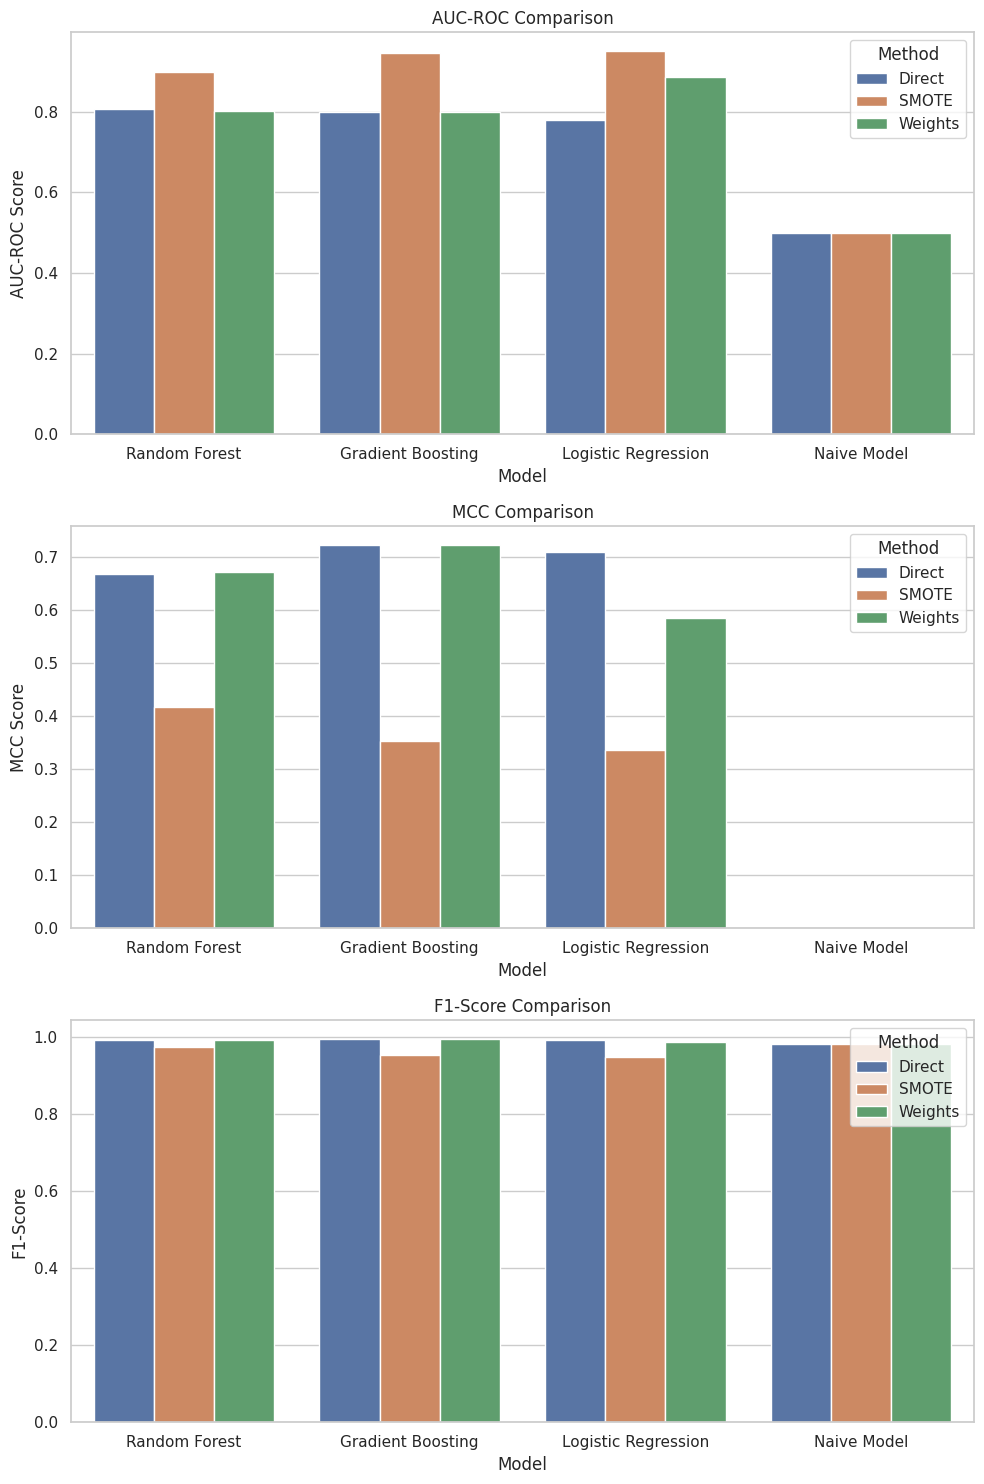

In [31]:


# Set up plotting
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# AUC-ROC Comparison
sns.barplot(x='Model', y='AUC-ROC', hue='Method', data=combined_results, ax=ax[0])
ax[0].set_title('AUC-ROC Comparison')
ax[0].set_ylabel('AUC-ROC Score')

# MCC Comparison
sns.barplot(x='Model', y='MCC', hue='Method', data=combined_results, ax=ax[1])
ax[1].set_title('MCC Comparison')
ax[1].set_ylabel('MCC Score')

# F1-Score Comparison
sns.barplot(x='Model', y='F1-Score', hue='Method', data=combined_results, ax=ax[2])
ax[2].set_title('F1-Score Comparison')
ax[2].set_ylabel('F1-Score')

plt.tight_layout()
plt.show()


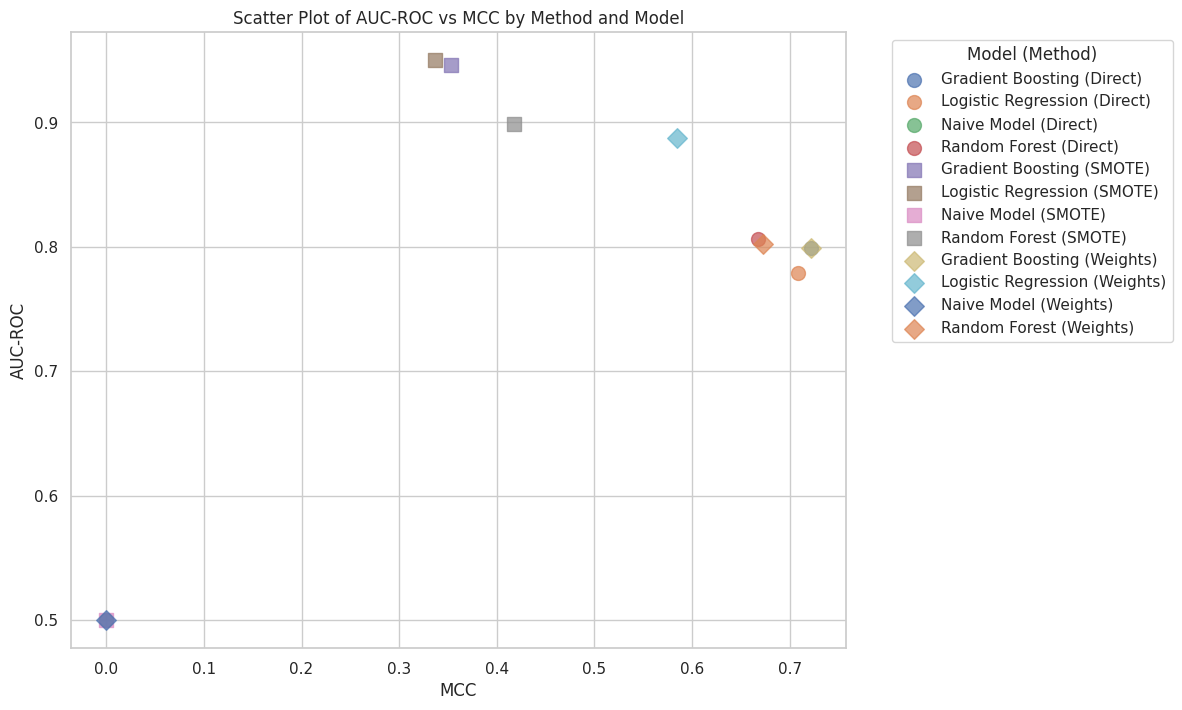

In [32]:
import matplotlib.pyplot as plt

# Creating a scatter plot of AUC-ROC vs MCC
plt.figure(figsize=(10, 8))

# Define markers for each method for distinction in the plot
markers = {'Direct': 'o', 'SMOTE': 's', 'Weights': 'D'}  # o: circle, s: square, D: diamond

# Plotting each model with a different color and method with different markers
for (method, model), group in combined_results.groupby(['Method', 'Model']):
    plt.scatter(group['MCC'], group['AUC-ROC'], label=f"{model} ({method})",
                marker=markers[method], s=100, alpha=0.7)  # Adjust alpha for better visibility

# Adding labels and title
plt.xlabel('MCC')
plt.ylabel('AUC-ROC')
plt.title('Scatter Plot of AUC-ROC vs MCC by Method and Model')
plt.legend(title='Model (Method)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


Given the performance metrics for each model-method combination, and considering the goal of balancing high ROC and MCC equally, **Gradient Boosting with Direct Method** stands out as the most balanced choice. Here’s the rationale for selecting this model:

### Key Metrics for Decision:
- **AUC-ROC (Area Under the Curve - Receiver Operating Characteristics):** Measures the ability of the model to distinguish between classes. Higher values indicate better predictive performance for identifying both positive and negative classes.
- **MCC (Matthews Correlation Coefficient):** Provides a balanced measure of the quality of binary classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure that can be used even if the classes are of very different sizes.

### Comparison of Gradient Boosting Metrics:
- **AUC-ROC**: 0.798786
- **MCC**: 0.721495

### Why Gradient Boosting with Direct Method:
1. **High MCC**: The MCC for Gradient Boosting under the Direct method is the highest across all models and methods, standing at 0.721495. This indicates a superior balance in prediction capabilities across all quadrants of the confusion matrix, which is crucial for scenarios like fraud detection where both types of errors (false positives and false negatives) have significant implications.
   
2. **Strong AUC-ROC**: Although not the absolute highest, its AUC-ROC is still competitive at 0.798786, suggesting robust ability to differentiate between the fraudulent and non-fraudulent classes. This AUC-ROC is quite balanced with its MCC, providing assurance of both good classification ability and error balance.

3. **Direct Method Simplicity**: The Direct method does not involve the complexities of SMOTE or class weights, which means the model performs this well without the need for balancing or synthetic sample generation. This simplicity can be advantageous for maintaining model performance and stability when deployed in production environments.

4. **Overall Performance Consistency**: Gradient Boosting consistently shows high performance across precision, recall, and F1-score, suggesting it handles both classes well under the direct implementation strategy.

### Final Thoughts:
While SMOTE improves AUC-ROC for some models, it tends to significantly lower the MCC, which is undesirable when considering the balance between detecting fraud accurately and maintaining low false positive and negative rates. Similarly, while class weights help in some cases, they do not consistently outperform the direct method for Gradient Boosting in terms of balancing both MCC and AUC-ROC.

**Gradient Boosting with the Direct method** thus emerges as the most effective model for a balanced, high-performance fraud detection system under the conditions and goals set forth.

In [ ]:
# Confusion Matrix

## Hypertuning GBM Direct Method (Random Search)

### Step 1: Setup for Hyperparameter Tuning

In [33]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, matthews_corrcoef, make_scorer
import matplotlib.pyplot as plt

# Assuming data_encoded2 is your dataset and is already loaded
X = data_encoded2.drop('fraud', axis=1)
y = data_encoded2['fraud']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### Step 2: Define the Parameter Grid

In [34]:
# Define a parameter distribution to search over
param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3]
}



### Step 3: Setup RandomizedSearchCV

In [35]:
# Create a GradientBoostingClassifier object
gb = GradientBoostingClassifier(random_state=42)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(estimator=gb, param_distributions=param_dist,
                                   n_iter=10, cv=3, scoring='roc_auc', n_jobs=-1,
                                   verbose=2, random_state=42)

# Fit the random search to the data
random_search.fit(X_train_scaled, y_train)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=42),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [3, 4, 5, 6],
                                        'min_samples_leaf': [1, 2, 3],
                                        'min_samples_split': [2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300, 400]},
                   random_state=42, scoring='roc_auc', verbose=2)

### Step 4: Evaluate the Tuned Model

In [ ]:
# Best estimator found by RandomizedSearchCV
best_gb = random_search.best_estimator_

# Predict on the test set using the best found parameters
y_pred = best_gb.predict(X_test_scaled)

# Calculate AUC-ROC and MCC
auc_roc = roc_auc_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)

# Print out the best parameters and the scores
print("Best parameters found: ", random_search.best_params_)
print("Best AUC-ROC from RandomizedSearch: ", random_search.best_score_)
print("Test AUC-ROC: ", auc_roc)
print("Test MCC: ", mcc)
